Cattral, R. & Oppacher, F. (2002). Poker Hand [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5KW38.

### Połączenie ze sparkiem i wczytanie plików

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession\
        .builder\
        .master("local[2]")\
        .appName("Create-DataFrame")\
        .config("spark.memory.offHeap.enabled","true")\
        .config("spark.memory.offHeap.size","6g")\
        .getOrCreate()
spark.sparkContext

sc = spark.sparkContext

In [ ]:
train_data = spark.read.csv('poker-hand-testing.data', header=None, inferSchema=True)
test_data = spark.read.csv('poker-hand-training-true.data', header=None, inferSchema=True)

In [ ]:
column_names = [
    'S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5', 'Class'
]
train_data_spark = train_data.toDF(*column_names)
test_data_spark = test_data.toDF(*column_names)

### Analiza eksploracyjna zbioru danych, wyświetlenie na wykresie podziału przypadków na klasy

In [ ]:
train_data_spark.describe().show()
df_train = train_data_spark

+-------+----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+
|summary|              S1|                C1|                S2|                C2|                S3|               C3|                S4|                C4|                S5|               C5|             Class|
+-------+----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+
|  count|         1000000|           1000000|           1000000|           1000000|           1000000|          1000000|           1000000|           1000000|           1000000|          1000000|           1000000|
|   mean|        2.500493|          6.997927|          2.499894|          7.006097|          2.500871|         6.998873|          2.500393| 

In [ ]:
test_data_spark.describe().show()

+-------+------------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+
|summary|                S1|               C1|               S2|               C2|                S3|                C3|                S4|                C4|                S5|               C5|             Class|
+-------+------------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+
|  count|             25010|            25010|            25010|            25010|             25010|             25010|             25010|             25010|             25010|            25010|             25010|
|   mean|2.5087564974010395|6.995241903238704|2.497720911635346|7.014194322271091| 2.510235905637745| 7.014154338264694| 2.495921631347461|6

In [ ]:
train_data_spark.show()

+---+---+---+---+---+---+---+---+---+---+-----+
| S1| C1| S2| C2| S3| C3| S4| C4| S5| C5|Class|
+---+---+---+---+---+---+---+---+---+---+-----+
|  1|  1|  1| 13|  2|  4|  2|  3|  1| 12|    0|
|  3| 12|  3|  2|  3| 11|  4|  5|  2|  5|    1|
|  1|  9|  4|  6|  1|  4|  3|  2|  3|  9|    1|
|  1|  4|  3| 13|  2| 13|  2|  1|  3|  6|    1|
|  3| 10|  2|  7|  1|  2|  2| 11|  4|  9|    0|
|  1|  3|  4|  5|  3|  4|  1| 12|  4|  6|    0|
|  2|  6|  4| 11|  2|  3|  4|  9|  1|  7|    0|
|  3|  2|  4|  9|  3|  7|  4|  3|  4|  5|    0|
|  4|  4|  3| 13|  1|  8|  3|  9|  3| 10|    0|
|  1|  9|  3|  8|  4|  4|  1|  7|  3|  5|    0|
|  4|  7|  3| 12|  1| 13|  1|  9|  2|  6|    0|
|  2| 12|  1|  3|  2| 11|  2|  7|  4|  8|    0|
|  4|  2|  2|  9|  2|  7|  1|  5|  3| 11|    0|
|  1| 13|  2|  6|  1|  6|  2| 11|  3|  5|    1|
|  3|  8|  2|  7|  1|  9|  3|  6|  2|  3|    0|
|  2| 10|  1| 11|  1|  9|  3|  1|  1| 13|    0|
|  4|  2|  4| 12|  2| 12|  2|  7|  3| 10|    1|
|  4|  5|  2|  2|  4|  9|  1|  5|  4|  1

### Sprawdzenie wartości brakujących

In [ ]:
from pyspark.sql.functions import isnan, when, count, col
df_train.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_train.columns]).show()

+---+---+---+---+---+---+---+---+---+---+-----+
| S1| C1| S2| C2| S3| C3| S4| C4| S5| C5|Class|
+---+---+---+---+---+---+---+---+---+---+-----+
|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|    0|
+---+---+---+---+---+---+---+---+---+---+-----+



### Plot rozkładu przypadków na klasy

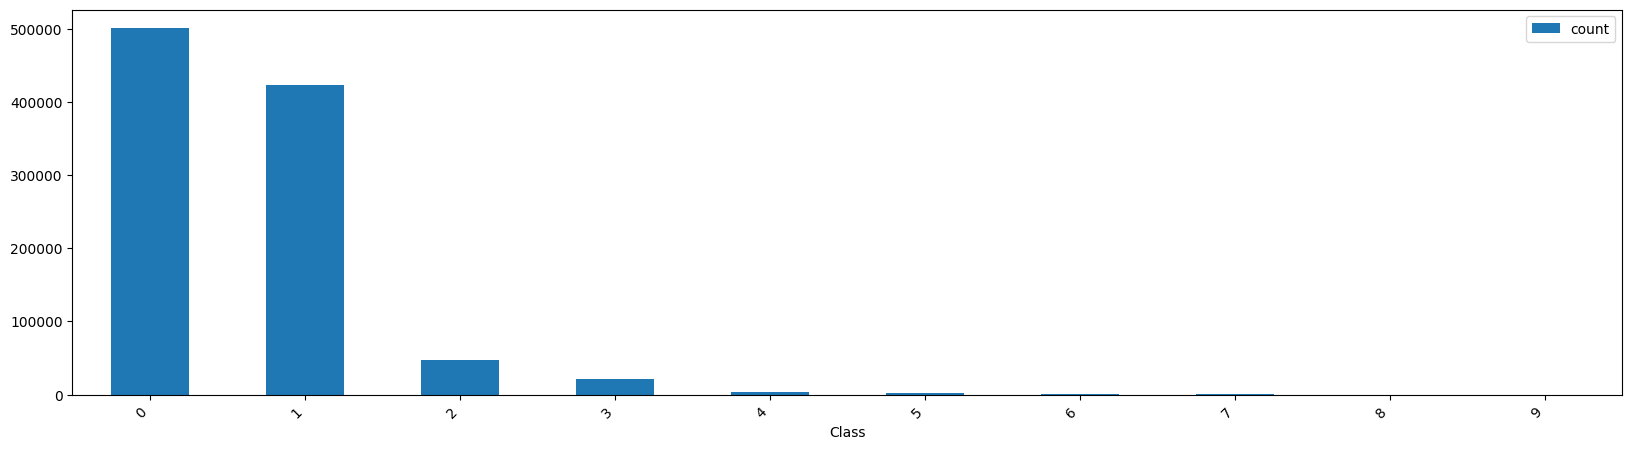

In [ ]:
import matplotlib.pyplot as plt
df_items = df_train.groupBy('Class').count().toPandas()
df_items_sorted = df_items.sort_values(by='count', ascending=False).head(20)
df_items_sorted.plot(kind='bar', x='Class', y='count', figsize=(20, 5))
plt.xticks(rotation=45, ha='right')
plt.show()

### Użycie VectorAssembler w celu przetworzenia zmiennych w jeden wektor

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

indexers = [
    StringIndexer(inputCol=f"S{i}", outputCol=f"S{i}_index").fit(train_data_spark) for i in range(1, 6)
]

assembler = VectorAssembler(
    inputCols=[f"S{i}_index" for i in range(1, 6)] + [f"C{i}" for i in range(1, 6)],
    outputCol="card_features"
)

pipeline = Pipeline(stages=indexers + [assembler])

model = pipeline.fit(train_data_spark)

df_transformed = model.transform(train_data_spark)

df_transformed.select("card_features", "Class").show(5)

+--------------------+-----+
|       card_features|Class|
+--------------------+-----+
|[1.0,0.0,3.0,1.0,...|    0|
|[0.0,2.0,0.0,2.0,...|    1|
|[1.0,1.0,2.0,0.0,...|    1|
|[1.0,2.0,3.0,1.0,...|    1|
|[0.0,3.0,2.0,1.0,...|    0|
+--------------------+-----+
only showing top 5 rows



### Split danych i klasyfikacja danych treningowych przez RandomForest

In [ ]:
train_data, test_data = df_transformed.randomSplit([0.8, 0.2], seed=42)

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

rf_classifier = RandomForestClassifier(featuresCol="card_features", labelCol="Class", numTrees=100)

rf_model = rf_classifier.fit(train_data)

In [ ]:
predictions = rf_model.transform(test_data)

predictions.select("prediction", "Class", "card_features").show(5)

evaluator = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

+----------+-----+--------------------+
|prediction|Class|       card_features|
+----------+-----+--------------------+
|       1.0|    1|[1.0,0.0,2.0,1.0,...|
|       0.0|    0|[1.0,0.0,2.0,0.0,...|
|       0.0|    0|[1.0,0.0,2.0,1.0,...|
|       1.0|    0|[1.0,0.0,2.0,2.0,...|
|       0.0|    0|[1.0,0.0,2.0,0.0,...|
+----------+-----+--------------------+
only showing top 5 rows

Accuracy: 0.5350931133608299


In [ ]:
precision_evaluator = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="f1")

precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)
f1_score = f1_evaluator.evaluate(predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1_score}")

Precision: 0.5180267734369856
Recall: 0.5350931133608299
F1-score: 0.4194762233164018


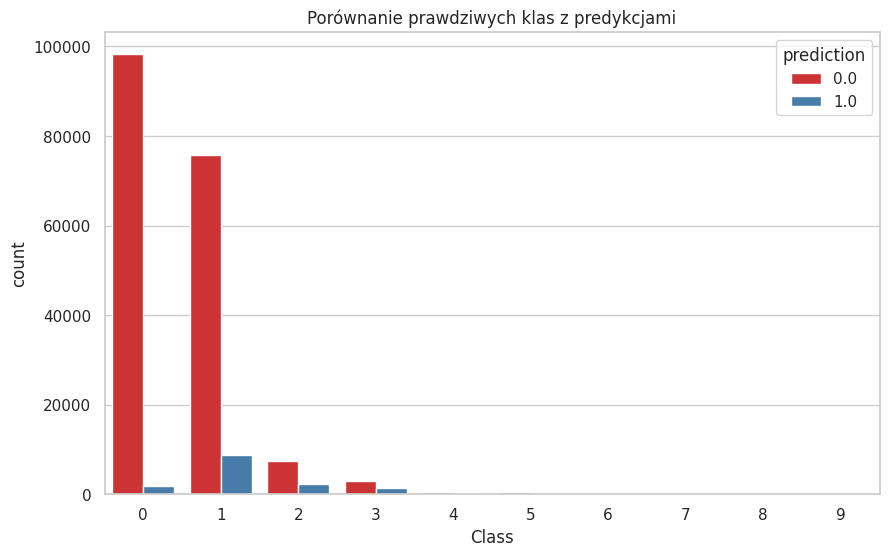

In [ ]:
predictions_pd = predictions.select("Class", "prediction").toPandas()

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.countplot(data=predictions_pd, x='Class', hue='prediction', palette='Set1')
plt.title('Porównanie prawdziwych klas z predykcjami')
plt.show()

In [ ]:
df_test_transformed = model.transform(test_data_spark)

In [ ]:
predictions_test = rf_model.transform(df_test_transformed)

predictions_test.select("prediction", "Class", "card_features").show(5)

accuracy_test = evaluator.evaluate(predictions_test)
print(f"Accuracy on test data: {accuracy_test}")

precision_test = precision_evaluator.evaluate(predictions_test)
recall_test = recall_evaluator.evaluate(predictions_test)
f1_test = f1_evaluator.evaluate(predictions_test)

print(f"Precision on test data: {precision_test}")
print(f"Recall on test data: {recall_test}")
print(f"F1-score on test data: {f1_test}")

+----------+-----+--------------------+
|prediction|Class|       card_features|
+----------+-----+--------------------+
|       0.0|    9|[1.0,0.0,2.0,3.0,...|
|       0.0|    9|[3.0,3.0,3.0,1.0,...|
|       0.0|    9|[0.0,2.0,0.0,0.0,...|
|       0.0|    9|[2.0,1.0,1.0,2.0,...|
|       0.0|    9|[2.0,1.0,1.0,2.0,...|
+----------+-----+--------------------+
only showing top 5 rows

Accuracy on test data: 0.5343862455017993
Precision on test data: 0.513819821790542
Recall on test data: 0.5343862455017993
F1-score on test data: 0.41979949264984123


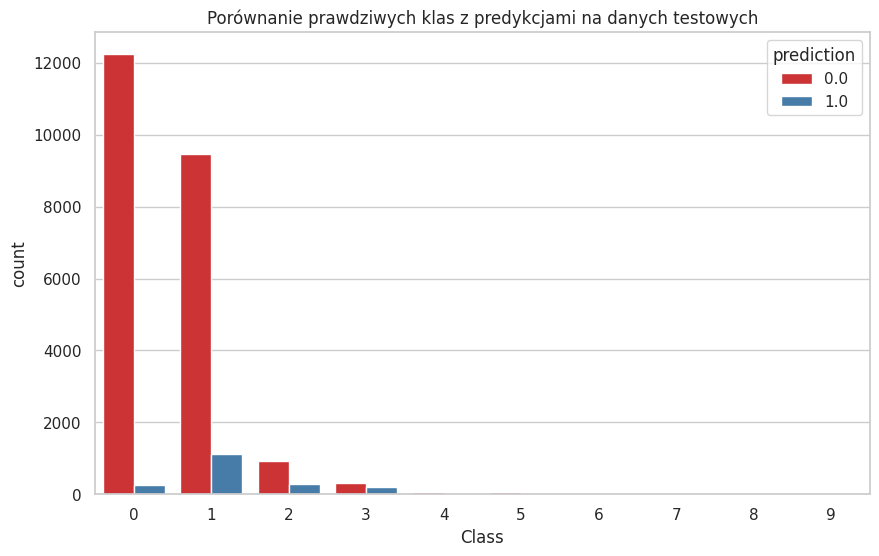

In [ ]:
predictions_test_pd = predictions_test.select("Class", "prediction").toPandas()

plt.figure(figsize=(10, 6))
sns.countplot(data=predictions_test_pd, x='Class', hue='prediction', palette='Set1')
plt.title('Porównanie prawdziwych klas z predykcjami na danych testowych')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd

predictions_test_pd = predictions_test.select("Class", "prediction").toPandas()

cm = confusion_matrix(predictions_test_pd['Class'], predictions_test_pd['prediction'])

print("Confusion Matrix for Test Data:")
print(cm)

Confusion Matrix for Test Data:
[[12240   253     0     0     0     0     0     0     0     0]
 [ 9474  1125     0     0     0     0     0     0     0     0]
 [  922   284     0     0     0     0     0     0     0     0]
 [  320   193     0     0     0     0     0     0     0     0]
 [   55    38     0     0     0     0     0     0     0     0]
 [   54     0     0     0     0     0     0     0     0     0]
 [   22    14     0     0     0     0     0     0     0     0]
 [    2     4     0     0     0     0     0     0     0     0]
 [    2     3     0     0     0     0     0     0     0     0]
 [    5     0     0     0     0     0     0     0     0     0]]


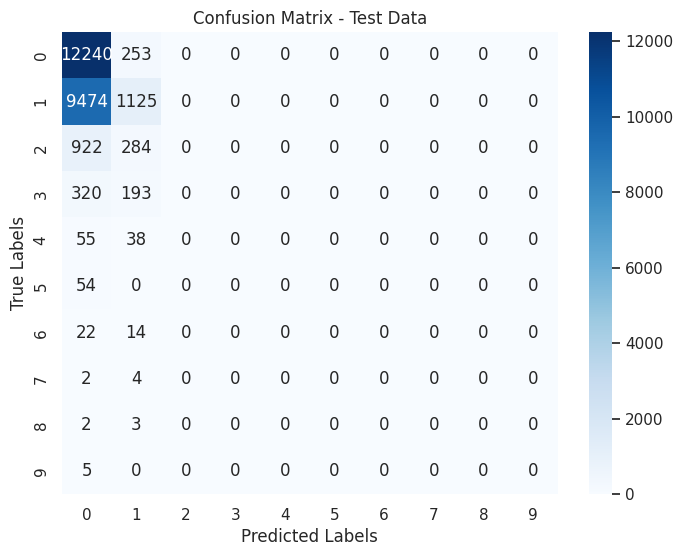

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Test Data')
plt.show()

## Jak widać prosty klasyfikator nie radzi sobie z rozpoznawaniem obiektów innych klas niż 0 i 1, prawdopodobnie ze względu na ilość próbek każdej z klas w zbiorze treningowym, przez co występuje faworyzacja dla częściej występujących klas

## Próba naprawy poprzez wagi dla klas bezpośrednio w modelu

In [ ]:
df = df_transformed
df_2 = df_test_transformed

In [ ]:
from pyspark.sql.functions import when

class_weights = {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 10}

df_transformed = df_transformed.withColumn(
    'weight',
    when(df_transformed['Class'] == 0, class_weights[0])
    .when(df_transformed['Class'] == 1, class_weights[1])
    .when(df_transformed['Class'] == 2, class_weights[2])
    .when(df_transformed['Class'] == 3, class_weights[3])
    .when(df_transformed['Class'] == 4, class_weights[4])
    .when(df_transformed['Class'] == 5, class_weights[5])
    .when(df_transformed['Class'] == 6, class_weights[6])
    .when(df_transformed['Class'] == 7, class_weights[7])
    .when(df_transformed['Class'] == 8, class_weights[8])
    .when(df_transformed['Class'] == 9, class_weights[9])
    .otherwise(1)
)

df_test_transformed = df_test_transformed.withColumn(
    'weight',
    when(df_test_transformed['Class'] == 0, class_weights[0])
    .when(df_test_transformed['Class'] == 1, class_weights[1])
    .when(df_test_transformed['Class'] == 2, class_weights[2])
    .when(df_test_transformed['Class'] == 3, class_weights[3])
    .when(df_test_transformed['Class'] == 4, class_weights[4])
    .when(df_test_transformed['Class'] == 5, class_weights[5])
    .when(df_test_transformed['Class'] == 6, class_weights[6])
    .when(df_test_transformed['Class'] == 7, class_weights[7])
    .when(df_test_transformed['Class'] == 8, class_weights[8])
    .when(df_test_transformed['Class'] == 9, class_weights[9])
    .otherwise(1)
)

df_transformed.select("Class", "weight").show(5)
df_test_transformed.select("Class", "weight").show(5)

+-----+------+
|Class|weight|
+-----+------+
|    0|     1|
|    1|     2|
|    1|     2|
|    1|     2|
|    0|     1|
+-----+------+
only showing top 5 rows

+-----+------+
|Class|weight|
+-----+------+
|    9|    10|
|    9|    10|
|    9|    10|
|    9|    10|
|    9|    10|
+-----+------+
only showing top 5 rows



In [ ]:
rf = RandomForestClassifier(labelCol="Class", featuresCol="card_features", weightCol="weight", numTrees=100, maxDepth=10)
rf_model = rf.fit(df_test_transformed)

predictions_test = rf_model.transform(df_test_transformed)

evaluator = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="accuracy")
accuracy_test = evaluator.evaluate(predictions_test)
print(f"Accuracy: {accuracy_test}")

Accuracy: 0.5183526589364255


In [ ]:
precision_evaluator = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="f1")

precision_test = precision_evaluator.evaluate(predictions_test)
recall_test = recall_evaluator.evaluate(predictions_test)
f1_test = f1_evaluator.evaluate(predictions_test)

print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"F1-score: {f1_test}")

Precision: 0.7682724186476483
Recall: 0.5183526589364256
F1-score: 0.43072281829893805


Confusion Matrix for Test Data:
[[ 2278 10215     0     0     0     0     0     0     0     0]
 [    3 10596     0     0     0     0     0     0     0     0]
 [    2  1176    28     0     0     0     0     0     0     0]
 [    0   472     0    41     0     0     0     0     0     0]
 [    0    93     0     0     0     0     0     0     0     0]
 [    6    36     0     0     0    12     0     0     0     0]
 [    0    33     0     0     0     0     3     0     0     0]
 [    0     6     0     0     0     0     0     0     0     0]
 [    0     4     0     0     0     0     0     0     1     0]
 [    0     0     0     0     0     0     0     0     0     5]]


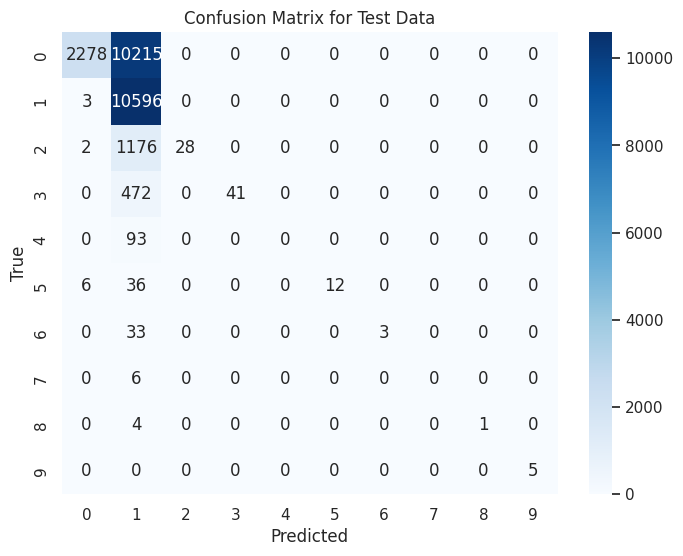

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd

predictions_test_pd = predictions_test.select("Class", "prediction").toPandas()

cm = confusion_matrix(predictions_test_pd['Class'], predictions_test_pd['prediction'])

print("Confusion Matrix for Test Data:")
print(cm)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(predictions_test_pd['Class']), yticklabels=np.unique(predictions_test_pd['Class']))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Test Data')
plt.show()

## Slaby model do tego przypadku bedzie mial slabe accuracy, ale przynajmniej precision sie zwiekszylo